# Image classification with Imagenette

This project is about classifying pictures from Imagenette, a subset of Imagenet created by Jeremy Howard (https://github.com/fastai/imagenette), containing 10 classes. The objective is to achieve the highest accuracy possible under specific constraints (size of 128px, 5 epochs and training from scratch).

A neural network will be implemented from scratch using Pytorch for this task. A comparison with the ResNet18 and ResNet50 architectures (without pre-trained weights) is also performed.

## Libraries

In [1]:
import gc
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import time
%matplotlib inline

import PIL

from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.models as models
import torchvision.transforms as transforms
from torchsummary import summary

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Custom Functions

In [2]:
def find_lr(loader:"DataLoader", model:"nn.Module", criterion:"loss function", optimizer:"optim.Optimizer",
            device:"torch.device", start_lr:float = 1e-8, end_lr:float = 10, max_it:int = 100, alpha:float = 0.98,
            filename:str = 'find_lr-model_initial_state.pt'):
    """
    """
    if not os.path.isfile(filename):
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, filename)

    coeff = (end_lr / start_lr) ** (1 / (max_it - 1))
    lr = start_lr
    optimizer.param_groups[0]['lr'] = lr # TODO: generalize
    avg_loss = 0.
    best_loss = 0.
    lrs = []
    losses = []

    it = 0
    iterator = iter(loader)

    while it < max_it:
        X, y = next(iterator)
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()
        outs = model(X)
        loss = criterion(outs, y)

        # Compute smoothed loss
        avg_loss = alpha * avg_loss + (1 - alpha) * loss.item()
        smoothed_loss = avg_loss / (1 - alpha ** (it+1))

        # Stop if loss is too high (exclude 1st iteration)
        if it > 0 and smoothed_loss > 4 * best_loss:
            return lrs, losses
        
        if smoothed_loss < best_loss or it == 0:
            best_loss = smoothed_loss
        
        lrs.append(lr)
        losses.append(smoothed_loss)

        loss.backward()
        optimizer.step()

        lr *= coeff
        optimizer.param_groups[0]['lr'] = lr
        it += 1

    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    return lrs, losses

def plot_lr(lrs:"List[float]", losses:"List[float]", figsize:"Tuple[float, float]" = (18, 6)):
    """
    """
    fig = plt.figure(figsize=figsize)
    plt.plot(lrs, losses)
    plt.xlabel('Learning rate')
    plt.ylabel('Loss')
    plt.xscale('log')

def find_and_plot_lr(loader:"DataLoader", model:"nn.Module", criterion:"loss function", optimizer:optim.Optimizer,
                     device:"torch.device", start_lr:float = 1e-8, end_lr:float = 10, max_it:int = 100, alpha:float = 0.98,
                     filename:str = 'find_lr-model_initial_state.pt', figsize:"Tuple[float, float]" = (18, 6)):
    """
    """
    lrs, losses = find_lr(loader, model, criterion, optimizer, device, start_lr, end_lr, max_it, alpha, filename)
    plot_lr(lrs, losses)

def train_classifier(model:"nn.Module", epochs:int, train_loader:"DataLoader", val_loader:"DataLoader",
                     criterion:"loss function", optimizer:"optim.Optimizer", scheduler:"LR scheduler",
                     device:"torch.device", threshold:float = 0.5) -> "List[float]":
    """
    """
    lrs = []

    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs} - ', end='')

        loss_epoch, val_loss_epoch = 0, 0
        acc_epoch, val_acc_epoch = 0, 0
        t0 = time.time()

        for phase in ['train', 'val']:
            running_loss = 0
            running_samples = 0
            running_corrects = 0
            running_tot = 0

            if phase == 'train':
                model.train()  # Set model to training mode
                loader = train_loader
                optimizer.zero_grad()
            else:
                model.eval()   # Set model to evaluate mode
                loader = val_loader

            for batch in loader:
                X, y = batch
                X, y = X.to(device), y.to(device)

                with torch.set_grad_enabled(phase == 'train'):
                    outs = model(X)
                    dims = len(y.shape)
                    if dims == 1: # Single label
                        y_pred = outs.argmax(1)
                    else:
                        y_pred = outs > threshold
                    loss = criterion(outs, y)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        scheduler.step()
                        optimizer.zero_grad()
                        lrs.append(optimizer.param_groups[0]['lr']) # TODO: generalize

                running_loss += loss.item() * X.shape[0] # Loss reduction='mean'
                running_samples += y.shape[0]
                running_corrects += torch.sum(y_pred == y).item()
                running_tot += y.nelement()
            
            if phase == 'train':
                loss_epoch = running_loss / running_samples
                acc_epoch = running_corrects / running_tot
            else:
                val_loss_epoch = running_loss / running_samples
                val_acc_epoch = running_corrects / running_tot

        duration = time.time() - t0
        print(f'{duration:.2f}s {duration * 1e3 / (len(train_loader) + len(val_loader)):.2f}ms/step - ', end='')
        print(f'loss: {loss_epoch}, acc: {acc_epoch} - val_loss: {val_loss_epoch}, val_acc: {val_acc_epoch}')

    return lrs

## Dataset Preparation

Load and prepare image dataset with the correct format (3 channels, 128px, 128px) and standardized pixel values (mean, std) = (0, 1) for the model. We also apply some data augmentation: random resized crop, horizontal flipping

In [3]:
%%shell

# # Download imagenette 160x160
wget https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-160.tgz
tar -xzf imagenette2-160.tgz

--2020-09-05 10:23:44--  https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-160.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.84.197
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.84.197|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 98948031 (94M) [application/x-tar]
Saving to: ‘imagenette2-160.tgz’

imagenette2-160.tgz 100%[===================>]  94.36M  38.9MB/s    in 2.4s    

2020-09-05 10:23:46 (38.9 MB/s) - ‘imagenette2-160.tgz’ saved [98948031/98948031]



In [4]:
class ImageDataset(Dataset):
    def __init__(self, root_dir:str, means=None, stds=None):
        self.df = self._get_img_from_dir(root_dir)
        # Transform string labels into class indices
        le = LabelEncoder()
        self.df['Encoded class'] = le.fit_transform(self.df['Class'])
        if means is not None and stds is not None:
            self.means, self.stds = means, stds
        else:
            self.means, self.stds = self._get_mean_std()
        self.PIL_tsfm = transforms.Compose([
            transforms.RandomResizedCrop((128, 128), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.Lambda(lambda img: img.convert('RGB')), # Convert to RGB (we may have grayscale images)
        ])
        self.tensor_tsfm = transforms.Compose([
            transforms.ToTensor(), # H x W x C [0, 255] -> C x H x W [0.0, 1.0]
            transforms.Normalize(self.means, self.stds),
        ])

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        X = self._get_processed_img(self.df['Img path'].iloc[idx])
        X = self.tensor_tsfm(X) # torch.FLOAT
        y = torch.tensor(self.df['Encoded class'].iloc[idx]) # torch.LONG
        return X, y

    def get_raw_img(self, idx):
        return PIL.Image.open(self.df['Img path'].iloc[idx])

    def get_img(self, idx):
        return self._get_processed_img(self.df['Img path'].iloc[idx])

    def _get_processed_img(self, path):
        img = PIL.Image.open(path)
        return self.PIL_tsfm(img)

    def _get_img_from_dir(self, path:str):
        paths = []
        labels = []
        for root, dirs, files in os.walk(path): # dirs not in order
            if files:
                tmp = [os.path.join(root, f) for f in files if '.jpeg' in f.lower()]
                paths.extend(tmp)
                labels.extend([root.split('/')[-1]] * len(tmp))

        df = pd.DataFrame()
        df['Img path'], df['Class'] = paths, labels
        return df

    def _get_mean_std(self):
        means = np.zeros(3)
        stds = np.zeros(3)
        px_tot = 0
        for path in self.df['Img path']:
            img = np.array(PIL.Image.open(path)) / 255.0
            tot = np.sum(img, axis=(0, 1))
            tot_square = np.sum(np.power(img, 2), axis=(0, 1))
            px = img.shape[0] * img.shape[1]
            if len(img.shape) != 3:
                tot = [tot] * 3
                tot_square = [tot_square] * 3
            means += tot
            stds += tot_square
            px_tot += px
        means /= px_tot
        stds = np.sqrt(stds / px_tot - means ** 2)
        return means, stds

train = ImageDataset('imagenette2-160/train')
val = ImageDataset('imagenette2-160/val', train.means, train.stds)

batch_size = 64
nb_workers = 4

train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=nb_workers, pin_memory=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=True, num_workers=nb_workers, pin_memory=True)

In [5]:
print(f'Size of dataset: {len(train)}, {len(val)}')

Size of dataset: 9469, 3925


Let's look at the classes distribution

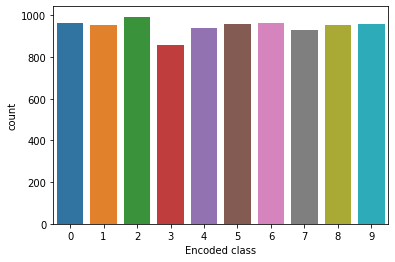

In [6]:
ax = sns.countplot(train.df['Encoded class'])

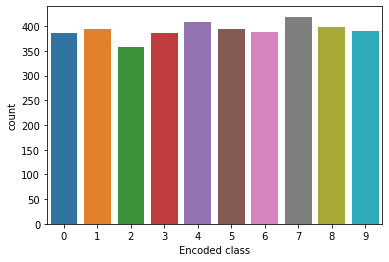

In [7]:
ax = sns.countplot(val.df['Encoded class'])

Classes are pretty balanced in train and val

Now, let's look at some pictures, original and after processing

In [8]:
# Set random seed for reproducibility
rng = np.random.default_rng(0)

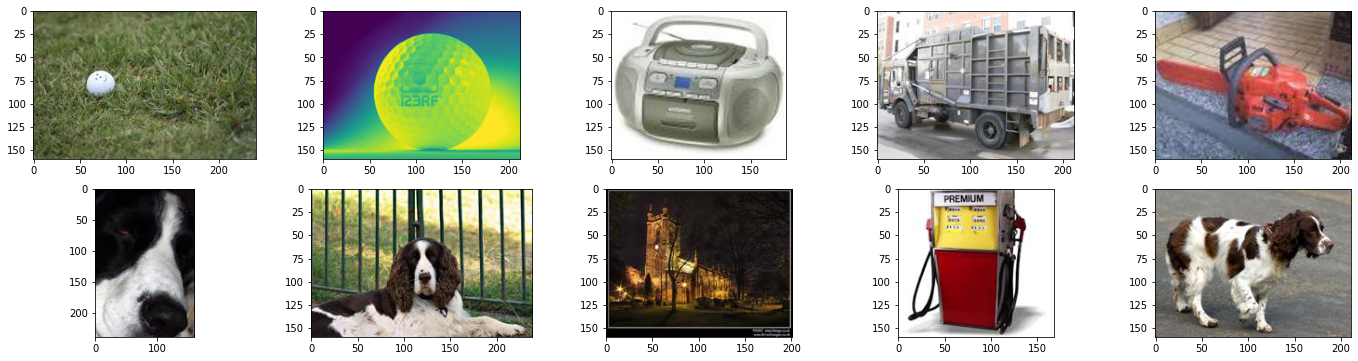

In [9]:
samples_id = rng.choice(len(train), size=10, replace=False)

fig, ax = plt.subplots(2, 5, figsize=(24, 6))
for i in range(2):
    for j in range(5):
        ax[i][j].imshow(np.array(train.get_raw_img(samples_id[5*i+j])))

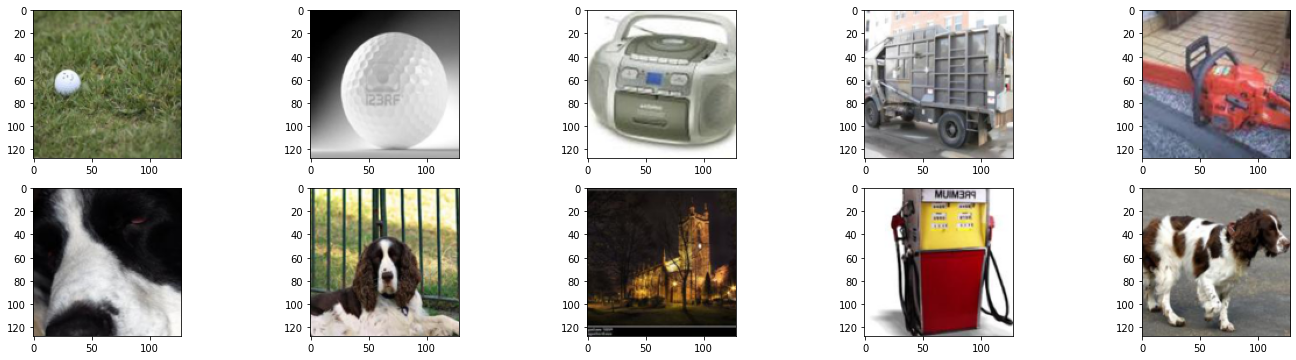

In [10]:
fig, ax = plt.subplots(2, 5, figsize=(24, 6))
for i in range(2):
    for j in range(5):
        ax[i][j].imshow(np.array(train.get_img(samples_id[5*i+j])))

Images have different sizes but we randomly crop and resize them to 128x128. They can also be distorted (Notice that grayscale images are displayed with a colormap)

Augmentating the dataset should help with the learning

## Models (custom ResNet18, ResNet)

Custom ResNet18:
- Similar to original ResNet but with some changes from https://arxiv.org/abs/1812.01187 among others
- Activation: ReLU
- Loss: cross-entropy
- Optimizer: SGD with one cycle policy

Pytorch's ResNet 18, 50 with 2 FC layers

In [11]:
#@title
class ConvBlock(nn.Module):
    def __init__(self, in_chan:int, out_chan:int , ker_sz:"Union[int, Tuple[int]]", stride:"Union[int, Tuple[int]]" = 1,
                 padding:str = 'same', padding_mode:str = 'reflect', activation:"activation module" = nn.ReLU,
                 order:"Tuple[str]" = ('conv', 'norm', 'act')):
        super(ConvBlock, self).__init__()
        self.order = order

        if padding == 'same':
            pad = ker_sz // 2
        else: # valid
            pad = 0

        if order.index('norm') < order.index('conv'):
            chan = in_chan
        else:
            chan = out_chan

        self.layers = []

        for l in order:
            if l == 'conv':
                self.layers.append(nn.Conv2d(in_chan, out_chan, ker_sz, stride=stride, padding=pad, padding_mode=padding_mode))
            elif l == 'norm':
                self.layers.append(nn.BatchNorm2d(chan))
            elif l == 'act':
                self.layers.append(activation(inplace=True))
        
        self.layers = nn.Sequential(*self.layers)

    def forward(self, x:torch.Tensor) -> torch.Tensor:
        return self.layers(x)

class StemBlock(nn.Module):
    """
    Slightly modified version (channels & strides) from https://arxiv.org/abs/1812.01187
    
    C_i, H, W -> C_o, H/4, W/4
    """
    def __init__(self, in_chan = 3, chans:"Sequence[int]" = [16, 32, 32], filt_k:"Sequence[int]" = [3, 3, 3],
                 filt_s:"Sequence[int]" = [1, 2, 1], padding_mode:str = 'reflect', pool_k:"Union[int, Tuple[int]]" = 3,
                 pool_s:"Union[int, Tuple[int]]" = 2, activation:"activation module" = nn.ReLU):
        """
        TODO: Generalize channels
        """
        super(StemBlock, self).__init__()
        chans = [in_chan] + chans
        self.conv = [ConvBlock(chans[i], chans[i+1], filt_k[i], stride=filt_s[i],
                               padding_mode=padding_mode, activation=activation) for i in range(len(filt_k))]
        self.conv = nn.Sequential(*self.conv)
        self.pad = (pool_k // 2,) * 4
        self.padding_mode = padding_mode
        self.pool = nn.MaxPool2d(pool_k, pool_s)

    def forward(self, x:torch.Tensor) -> torch.Tensor:
        x = self.conv(x)
        x = F.pad(x, self.pad, mode=self.padding_mode)
        return self.pool(x)

class ResBlock(nn.Module):
    """
    Slightly modified version from https://arxiv.org/abs/1812.01187

    Resnet34 and inferior use `conv_k = [3, 3, 1]`
    """
    def __init__(self, in_chan:int, chans:"Union[int, Sequence[int]]", block_type:str = 'basic', downsample:"Optional[str]" = None,
                 expansion:"Optional[int]" = None, conv_k:"Optional[Sequence[int]]" = None,
                 conv_s:"Optional[Sequence[int]]" = None, padding_mode:str = 'reflect',
                 pool_k:"Union[int, Tuple[int]]" = 2, pool_s:"Union[int, Tuple[int]]" = 2, id_k:"Union[int, Tuple[int]]" = 1,
                 id_s:"Union[int, Tuple[int]]" = 1, activation:"activation module" = nn.ReLU,
                 order:"Tuple[str]" = ('conv', 'norm', 'act')):
        super(ResBlock, self).__init__()

        if block_type == 'basic':
            expansion = 1
            conv_k = [3, 3]
            if downsample is not None:
                conv_s = [1, 2]
            else:
                conv_s = [1, 1]
        elif block_type == 'bottleneck':
            expansion = 4
            conv_k = [1, 3, 1]
            if downsample is not None:
                conv_s = [1, 2, 1]
            else:
                conv_s = [1, 1, 1]
        else:
            pass # TODO: check other arguments are valid        

        if isinstance(chans, int):
            tmp = chans
            chans = [in_chan]
            if downsample is not None:
                ds_idx = conv_s.index(2)
                chans += [tmp // 2] * ds_idx + [tmp] * (len(conv_s) - ds_idx - 1)
            else:
                chans += [tmp] * (len(conv_s) - 1)
            chans.append(tmp * expansion)
        else: # TODO: Check if sequence
            chans = [in_chan] + list(chans)
        
        # Convolutional path
        self.conv = [ConvBlock(chans[i], chans[i+1], conv_k[i], stride=conv_s[i], padding_mode=padding_mode,
                               activation=activation, order=['norm', 'act', 'conv']) for i in range(len(conv_k))]
        self.conv = nn.Sequential(*self.conv)

        # Identity path
        if downsample is None:
            if in_chan == chans[-1]:
                self.identity = nn.Identity()
            else:
                self.identity = ConvBlock(chans[0], chans[-1], id_k, stride=id_s, padding_mode=padding_mode,
                                          activation=activation, order=['norm', 'act', 'conv'])
        else:
            if downsample == 'avg':
                Pool = nn.AvgPool2d
            elif downsample == 'max':
                Pool = nn.MaxPool2d

            self.identity = nn.Sequential(
                Pool(pool_k, pool_s),
                ConvBlock(chans[0], chans[-1], id_k, stride=id_s, padding_mode=padding_mode,
                          activation=activation, order=['norm', 'act', 'conv']),
            )

    def forward(self, x:torch.Tensor) -> torch.Tensor:
        return self.conv(x) + self.identity(x)

def create_resnet_base(blocks:"Sequence[int]", block_type, in_chan:int = 3, stem_chans:"Sequence[int]" = [16, 32, 32],
                       res_chans:"Sequence[int]" = [64, 128, 256, 512], expansion:"Optional[int]" = None, *kwargs):
    # TODO: refactor, also in ResBlock
    if block_type == 'basic':
        expansion = 1
    elif block_type == 'bottleneck':
        expansion = 4

    layers = []
    layers.append(StemBlock(in_chan, stem_chans)) # TODO: add other arguments
    layers += [ResBlock(stem_chans[-1], res_chans[0], block_type=block_type, expansion=expansion, *kwargs)]
    layers += [ResBlock(res_chans[0] * expansion, res_chans[0], block_type=block_type, expansion=expansion,
                        *kwargs) for _ in range(1, blocks[0])]
    for i in range(1, len(blocks)):
        layers += [ResBlock(res_chans[i-1] * expansion, res_chans[i], block_type=block_type, downsample='avg',
                            expansion=expansion, *kwargs)]
        layers += [ResBlock(res_chans[i] * expansion, res_chans[i], block_type=block_type, expansion=expansion,
                            *kwargs) for _ in range(1, blocks[i])]

    return nn.Sequential(*layers)

def resnet18():
    blocks = [2, 2, 2, 2]
    return create_resnet_base(blocks, 'basic')

In [12]:
class MyResNet(nn.Module):
    def __init__(self):
        super(MyResNet, self).__init__()
        self.conv = resnet18()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 10), # No need of softmax as it's done within cross entropy loss
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.pool(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc(x)
        return x

In [13]:
class ResNet(nn.Module):
    def __init__(self, nb_layers, neurons):
        super(ResNet, self).__init__()
        if nb_layers == 18:
            self.model = models.resnet18()
        elif nb_layers == 50:
            self.model = models.resnet50()
        else:
            raise RuntimeError(f'{nb_layers} is not a valid argument')

        nb_features = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Linear(nb_features, neurons),
            nn.BatchNorm1d(neurons),
            nn.ReLU(),
            nn.Linear(neurons, 10),
        )

    def forward(self, x):
        return self.model(x)

## Training

Before training each model, we find a good learning rate by scanning a range of learning rates as suggested by Leslie N. Smith in [Cyclical Learning Rates for Training Neural Networks](https://arxiv.org/abs/1506.01186.pdf)

In [14]:
# Define device variable for switching between CPU/GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

epochs = 5
criterion = nn.CrossEntropyLoss()

Device: cuda


### ResNet50

In [15]:
model = ResNet(50, 128)
model.to(device)
summary(model, (3, 128, 128))

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]           4,096
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
           Conv2d-11          [-1, 256, 32, 32]          16,384
      BatchNorm2d-12          [-1, 256, 32, 32]             512
           Conv2d-13          [-1, 256, 32, 32]          16,384
      BatchNorm2d-14          [-1, 256,

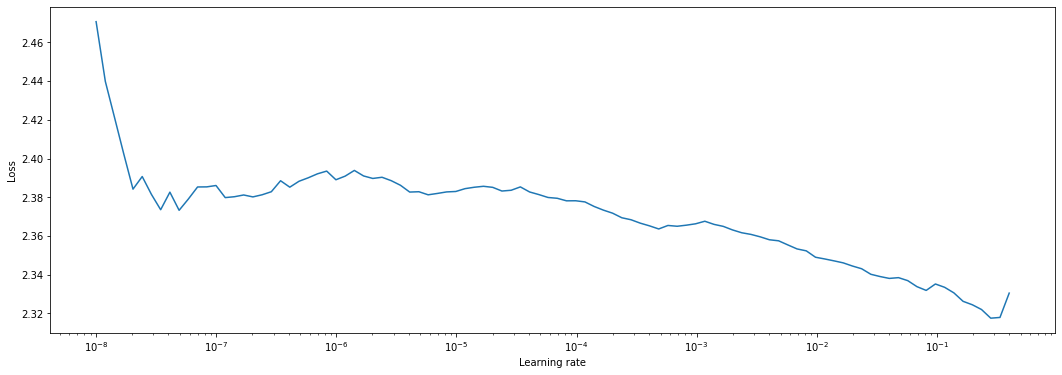

In [16]:
gc.collect() # Free some useless memory

find_and_plot_lr(train_loader, model, criterion, optimizer, device, end_lr=4e-1, filename='pytorch-resnet50-init')

In [17]:
lr = 1e-2

scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, steps_per_epoch=len(train_loader), epochs=epochs)

lrs = train_classifier(model, epochs, train_loader, val_loader, criterion, optimizer, scheduler, device)

Epoch 1/5 - 40.23s 191.55ms/step - loss: 2.219554613656058, acc: 0.18650332664484107 - val_loss: 2.3045419616456244, val_acc: 0.2270063694267516
Epoch 2/5 - 40.95s 195.01ms/step - loss: 1.8714043761724806, acc: 0.34734396451578836 - val_loss: 1.883965020999787, val_acc: 0.36713375796178344
Epoch 3/5 - 41.63s 198.23ms/step - loss: 1.5474094147792474, acc: 0.47058823529411764 - val_loss: 1.5161541309174458, val_acc: 0.4896815286624204
Epoch 4/5 - 42.16s 200.77ms/step - loss: 1.3169775066059486, acc: 0.5511669658886894 - val_loss: 1.3171475929667236, val_acc: 0.5622929936305733
Epoch 5/5 - 42.20s 200.95ms/step - loss: 1.077904056591272, acc: 0.6436793748019854 - val_loss: 1.2295144009742007, val_acc: 0.5928662420382166


### ResNet18

In [18]:
model = ResNet(18, 128)
model.to(device)
summary(model, (3, 128, 128))

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
       BasicBlock-11           [-1, 64, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          36,864
      BatchNorm2d-13           [-1, 64, 32, 32]             128
             ReLU-14           [-1, 64,

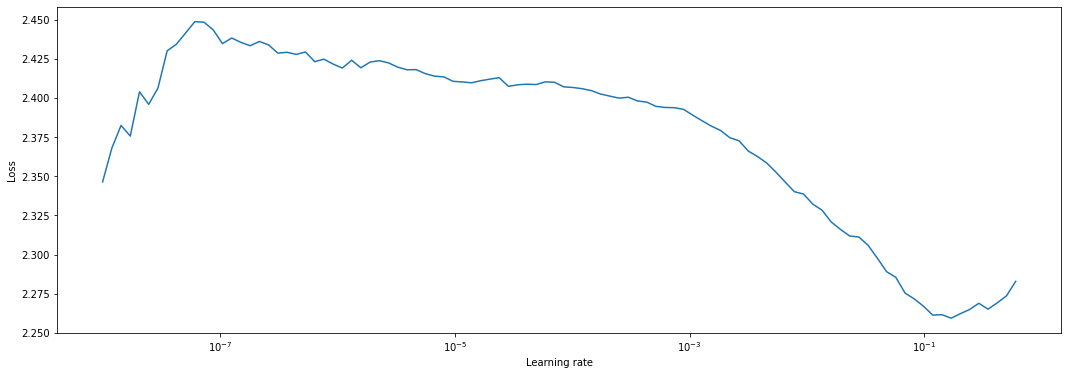

In [19]:
gc.collect() # Free some useless memory

find_and_plot_lr(train_loader, model, criterion, optimizer, device, end_lr=6e-1, filename='pytorch-resnet18-init')

In [20]:
lr = 1e-2

scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, steps_per_epoch=len(train_loader), epochs=epochs)

lrs = train_classifier(model, epochs, train_loader, val_loader, criterion, optimizer, scheduler, device)

Epoch 1/5 - 22.98s 109.43ms/step - loss: 1.929330062823407, acc: 0.3235822156510719 - val_loss: 1.8419504680451315, val_acc: 0.38012738853503186
Epoch 2/5 - 22.84s 108.76ms/step - loss: 1.2863990941638364, acc: 0.5710212271623192 - val_loss: 1.6893917725192513, val_acc: 0.4743949044585987
Epoch 3/5 - 23.00s 109.50ms/step - loss: 1.0070091775156325, acc: 0.6729327278487697 - val_loss: 1.2172514672795678, val_acc: 0.6086624203821656
Epoch 4/5 - 22.84s 108.74ms/step - loss: 0.7687245977568216, acc: 0.752877811806949 - val_loss: 0.8902646302721303, val_acc: 0.7149044585987261
Epoch 5/5 - 22.94s 109.23ms/step - loss: 0.5539952560304047, acc: 0.8320836413560038 - val_loss: 0.8028071611853922, val_acc: 0.7398726114649682


### Custom ResNet18

In [21]:
model = MyResNet()
model.to(device)
summary(model, (3, 128, 128))

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]             448
       BatchNorm2d-2         [-1, 16, 128, 128]              32
              ReLU-3         [-1, 16, 128, 128]               0
         ConvBlock-4         [-1, 16, 128, 128]               0
            Conv2d-5           [-1, 32, 64, 64]           4,640
       BatchNorm2d-6           [-1, 32, 64, 64]              64
              ReLU-7           [-1, 32, 64, 64]               0
         ConvBlock-8           [-1, 32, 64, 64]               0
            Conv2d-9           [-1, 32, 64, 64]           9,248
      BatchNorm2d-10           [-1, 32, 64, 64]              64
             ReLU-11           [-1, 32, 64, 64]               0
        ConvBlock-12           [-1, 32, 64, 64]               0
        MaxPool2d-13           [-1, 32, 32, 32]               0
        StemBlock-14           [-1, 32,

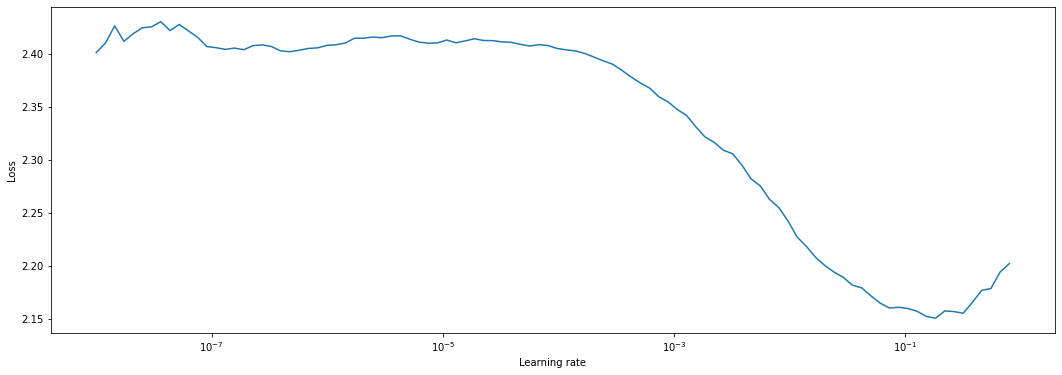

In [22]:
gc.collect() # Free some useless memory

find_and_plot_lr(train_loader, model, criterion, optimizer, device, end_lr=8e-1, filename='custom-resnet18-init')

A good learning rate seems to be around 1e-3 so we'll use this value and train the model for 5 epochs with the one cycle learning rate policy

In [23]:
lr = 1e-2

scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, steps_per_epoch=len(train_loader), epochs=epochs)

lrs = train_classifier(model, epochs, train_loader, val_loader, criterion, optimizer, scheduler, device)

Epoch 1/5 - 26.35s 125.49ms/step - loss: 1.6673478556857693, acc: 0.44144049002006547 - val_loss: 1.727327376930577, val_acc: 0.44789808917197454
Epoch 2/5 - 26.25s 124.98ms/step - loss: 1.1007949981823908, acc: 0.6434681592565212 - val_loss: 1.2904351252659112, val_acc: 0.5803821656050956
Epoch 3/5 - 26.11s 124.35ms/step - loss: 0.8951377129243789, acc: 0.7119019959869046 - val_loss: 0.8434424435409011, val_acc: 0.7347770700636943
Epoch 4/5 - 26.44s 125.90ms/step - loss: 0.6979624468631384, acc: 0.77737881508079 - val_loss: 0.7762714557283243, val_acc: 0.7454777070063694
Epoch 5/5 - 26.86s 127.88ms/step - loss: 0.5213234480016019, acc: 0.836730383356215 - val_loss: 0.6139245146095373, val_acc: 0.8020382165605096


The accuracies on the validation set for ResNet50 and ResNet18 after 5 runs are 59.29% and 73.99% respectively. Regarding the custom ResNet18 architecture, it outperforms the previous two with a 80.20% accuracy.

As a reference, the best accuracy on Imagenette is 85.27% for 5 runs  as of 5 September 2020.